## 병렬 노드 실행을 위한 분기 생성 방법

노드의 병렬실행은 저체 그래프 작업의 속도를 향상시키는데 필수적. LangGraph는 노드의 병렬 실행을 기본적으로 지원, 이는 그래프 기반 워크플로우의 성능을 크게 향상 시킬 수 있다.<br><br>
병렬화는 **fan-out** 과 **fan-in** 메커니즘을 통해 구현되며, 표준 엣지와 **conditional_edges**를 활용.

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

logging.langsmith("LangGraph-Modules")
load_dotenv()

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Modules


True

## 병렬 노드 fan-out 및 fan-in

### fan-out / fan-in

병렬 처리에서 fan-out과 fan-in은 작업을 나누고 모으는 과정.
- fan-out: 하나의 노드에서 여러 노드로 작업을 분산.
- fan-in: 여러 노드에서 하나의 노드로 작업을 모음.

In [2]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    aggregate: Annotated[list, add_messages]

# 노드 값 반환 클래스
class RetrunNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret
    
    # 호출 시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}

# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 A부터 D까지 생성 및 값 할당
builder.add_node("a", RetrunNodeValue("I'm A"))
builder.add_edge(START, "a")

builder.add_node("b", RetrunNodeValue("I'm B"))
builder.add_node("c", RetrunNodeValue("I'm C"))
builder.add_node("d", RetrunNodeValue("I'm D"))

# 노드 연결
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()



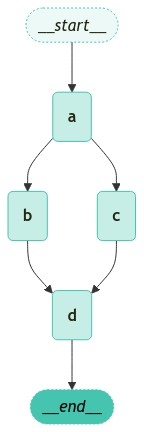

In [3]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [4]:
# 그래프 실행
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='77474f00-3d09-4a36-803f-5c5be4302eed')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='77474f00-3d09-4a36-803f-5c5be4302eed')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='77474f00-3d09-4a36-803f-5c5be4302eed'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='b46a4e51-7029-474a-86db-4e6705c83728'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='5d9b6c3d-9fa9-4cbe-a6ef-a20e33398cac')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='77474f00-3d09-4a36-803f-5c5be4302eed'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='b46a4e51-7029-474a-86db-4e6705c83728'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='5d9b6c3d-9fa9-4cbe-a6ef-a20e33398cac'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='79a1842c-14ce-4d49-ae6e-ddb878f0da43')]}

오류가 발생하기 쉬운 작업(예: 불안정한 API 호출 처리)이 있는 경우, 두 가지 방법 존재.

1. 노드 내에서 일반적인 Python 코드를 작성하여 예외를 포착하고 처리 가능.
2. retry_policy 를 설정하여 특정 유형의 예외가 발생한 노드를 재시도하도록 그래프를 지시 가능.<br><br>

실패한 분기만 재시도되므로 불필요한 작업 수행 안함.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 생성
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 노드 연결
builder.add_edge("a", "b1")
builder.add_edge("a", "c")
builder.add_edge("b1", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

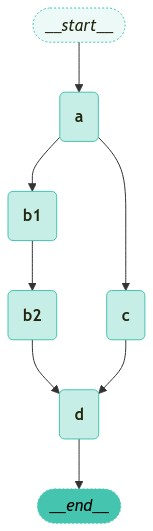

In [6]:

from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [7]:
# 빈 리스트를 사용한 그래프 집계 연산 실행, 모든 데이터에 대한 기본 집계 수행
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm B1 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e7167431-48d7-4082-a9d9-4593592949e4')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e7167431-48d7-4082-a9d9-4593592949e4')]
Adding I'm B2 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e7167431-48d7-4082-a9d9-4593592949e4'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='675e5ebe-e8a9-4348-9a7f-eecff79b1a32'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='5b309e92-1466-438e-b77a-524c24278de5')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e7167431-48d7-4082-a9d9-4593592949e4'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='675e5ebe-e8a9-4348-9a7f-eecff79b1a32'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='5b309

{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e7167431-48d7-4082-a9d9-4593592949e4'),
  HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='675e5ebe-e8a9-4348-9a7f-eecff79b1a32'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='5b309e92-1466-438e-b77a-524c24278de5'),
  HumanMessage(content="I'm B2", additional_kwargs={}, response_metadata={}, id='7650fb56-9156-4785-bb9c-1ca8dcdd325d'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='5ee69c1e-0663-4123-8798-a9d7841987bc')]}

## 조건부 분기(Conditional branching)

fan-out이 결정적이지 않은 경우, add_conditional_edges를 직접 사용 가능.<br><br>
조건부 분기 이후 연결된 알려진 'sink' 노드가 있는 경우, 조건부 엣지를 생성할 때 then="실행할 노드명" 제공 가능.

In [8]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# 상태 정의
class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    which: str

# 노드별 고유 값을 반환하는 클래스
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}
    
# 상태 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))

# 상태의 'which' 값에 따른 조건부 라우팅 경로 결정 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state['which'] == 'cd':
        return ['c','d']
    return ['b','c']

intermediates = ['b','c','d']

builder.add_conditional_edges(
    'a',
    route_bc_or_cd,
    intermediates,
)

for node in intermediates:
    builder.add_edge(node, 'e')


builder.add_edge('e',END)
graph = builder.compile()

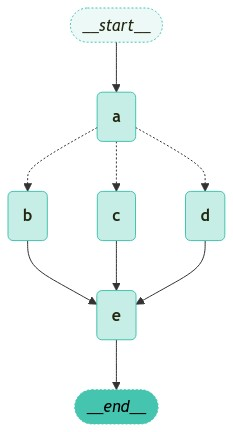

In [9]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [10]:
# 그래프 실행(which: bc 로 지정)
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='af62bad1-3350-499f-9118-c55bc62954f2')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='af62bad1-3350-499f-9118-c55bc62954f2')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='af62bad1-3350-499f-9118-c55bc62954f2'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='a61c4f62-b25e-4736-aba7-561e13b3daa4'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='15b7b450-fb7f-4895-8dec-23f16ca629dd')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='af62bad1-3350-499f-9118-c55bc62954f2'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='a61c4f62-b25e-4736-aba7-561e13b3daa4'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='15b7b450-fb7f-4895-8dec-23f16ca629dd'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='aff8d183-d062-4909-9c3d-e8a704c4d741')],
 'which': 'bc'}

In [14]:
# 그래프 실행(which: cd 로 지정)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ba56f336-a29d-4853-86f4-cd8ded2ea36c')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ba56f336-a29d-4853-86f4-cd8ded2ea36c')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ba56f336-a29d-4853-86f4-cd8ded2ea36c'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='10403d2b-4725-47c3-977a-7a9fff577fa0'), HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='cd660464-e209-41ab-a089-433b3f347493')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ba56f336-a29d-4853-86f4-cd8ded2ea36c'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='10403d2b-4725-47c3-977a-7a9fff577fa0'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='cd660464-e209-41ab-a089-433b3f347493'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='2c7466b6-bbb0-4367-a033-639fc14929b7')],
 'which': 'cd'}

## fan-out 값의 신뢰도에 따른 정렬

병렬로 펼쳐진 노드들은 하나의 "super-step"으로 실행됩니다. 각 super-step 에서 발생한 업데이트들은 해당 super-step 이 완료된 후 순차적으로 상태에 적용됩니다.

병렬 super-step 에서 일관된 사전 정의된 업데이트 순서가 필요한 경우, 출력값을 식별 키와 함께 상태의 별도 필드에 기록한 다음, 팬아웃된 각 노드에서 집결 지점까지 일반 edge 를 추가하여 "sink" 노드에서 이들을 결합해야 합니다.



In [15]:
# 팬아웃 값들의 병합 로직 구현, 빈 리스트 처리 및 리스트 연결 수행
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # 덮어쓰기
        return []
    return left + right


# 상태 관리를 위한 타입 정의, 집계 및 팬아웃 값 저장 구조 설정
class State(TypedDict):
    # add_messages 리듀서 사용
    aggregate: Annotated[list, add_messages]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


# 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")


# 병렬 노드 값 반환 클래스
class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


# 신뢰도(reliability)가 다른 병렬 노드들 추가
builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.1))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.9))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.5))


# 팬아웃 값들을 신뢰도 기준으로 정렬하고 최종 집계 수행
def aggregate_fanout_values(state: State) -> Any:
    # 신뢰도 기준 정렬
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    print(ranked_values)
    return {
        "aggregate": [x["value"][0] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


# 집계 노드 추가
builder.add_node("e", aggregate_fanout_values)


# 상태에 따른 조건부 라우팅 로직 구현
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 중간 노드들 설정 및 조건부 엣지 추가
intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates)

# 중간 노드들과 최종 집계 노드 연결
for node in intermediates:
    builder.add_edge(node, "e")

# 그래프 완성을 위한 최종
graph = builder.compile()

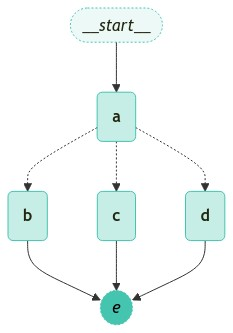

In [16]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

병렬로 노드 실행시 결과를 reliability 기준으로 정렬합니다.
- b: reliability=0.1
- c: reliability=0.9
- d: reliability=0.5

In [17]:
# 그래프 실행(which: bc 로 지정)
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='70404bcd-cd39-43b1-a50c-e95711331e70')] in parallel.
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='70404bcd-cd39-43b1-a50c-e95711331e70')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm B"], 'reliability': 0.1}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='70404bcd-cd39-43b1-a50c-e95711331e70'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='15094680-8c19-498e-8b13-f5cb6af5d93c'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='d97f646d-8818-48cb-87f6-8d06a0fe1c54'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='e4bfffa9-d7e5-41cb-9259-4a0c94b096ff')],
 'fanout_values': [],
 'which': 'bc'}

In [21]:
# 그래프 실행(which: cd 로 지정)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='0249d4f2-57df-476a-83c7-28221f9e6e76')] in parallel.
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='0249d4f2-57df-476a-83c7-28221f9e6e76')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm D"], 'reliability': 0.5}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='0249d4f2-57df-476a-83c7-28221f9e6e76'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='c6189674-0b75-46a4-af92-1250b18c5bf4'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='b9e0c658-7753-44a8-974e-8ce0dab08d99'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='a0534a51-db9d-45a3-835e-1d137b68a044')],
 'fanout_values': [],
 'which': 'cd'}